## Data Scientist Assessment 

Develop a model to predict a player’s rank.

In [144]:
import pandas as pd
import numpy as np # linear algebra

#EDA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import boxcox1p
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy import stats

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neural_network import MLPClassifier

from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [145]:
df = pd.read_csv('starcraft_player_data.csv')
df

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.000000,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.000000,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.000000,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.000000,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.000000,0.000019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,10089,8,?,?,?,259.6296,0.020425,0.000743,9,0.000621,0.000146,0.004555,18.6059,42.8342,6.2754,46,0.000877,5,0.000000,0.000000
3391,10090,8,?,?,?,314.6700,0.028043,0.001157,10,0.000246,0.001083,0.004259,14.3023,36.1156,7.1965,16,0.000788,4,0.000000,0.000000
3392,10092,8,?,?,?,299.4282,0.028341,0.000860,7,0.000338,0.000169,0.004439,12.4028,39.5156,6.3979,19,0.001260,4,0.000000,0.000000
3393,10094,8,?,?,?,375.8664,0.036436,0.000594,5,0.000204,0.000780,0.004346,11.6910,34.8547,7.9615,15,0.000613,6,0.000000,0.000631


Here the LeagueIndex is the rank (stated by the problem). 

My plan of action includes: 
1. Perform EDA 
2. Decide what do with Nan values (ex. '?') 
3. Spilt the data into training and test set 
4. Train ML model with training data 
5. Apply ML model to Test data 

### Performing EDA

Identify Anomalies/ Missing Data

In [146]:
# df.dtypes
# df["Age"] = df["Age"].astype(int)
# print (df.dtypes)
print("# of missing vals in Age: ", (df['Age'] == '?').sum())
print("# of missing vals in Age: ", (df['HoursPerWeek'] == '?').sum())
print("# of missing vals in Age: ", (df['TotalHours'] == '?').sum())

# of missing vals in Age:  55
# of missing vals in Age:  56
# of missing vals in Age:  57


In [147]:
df_no_question_marks = df[df.Age != '?']
df_no_question_marks = df[df.HoursPerWeek != '?']
df_no_question_marks = df[df.TotalHours != '?']
# df_no_question_marks

In [148]:
df_no_question_marks = df_no_question_marks.drop(columns = 'GameID')


1. Average UniqueHotKeys per Rank(EDA), 
2. Average TotalMapExplored per rank(EDA), 
3. Average WorkersMade per rank(EDA) - WorkersMade: Number of SCVs, drones, and probes trained per timestamp

For all of these features, the higher the rank the higher the average. We can draw from these graphs that there may be some correlation between these features and the player's rank. We can use this to build our model. 

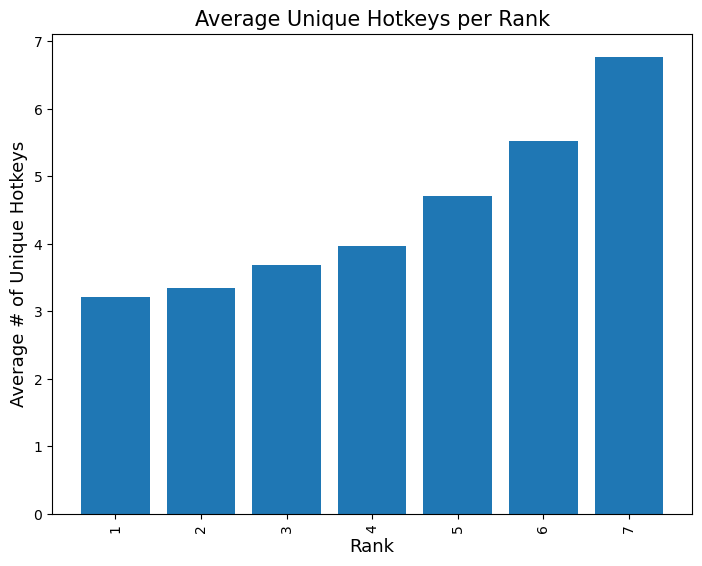

<Figure size 640x100 with 0 Axes>

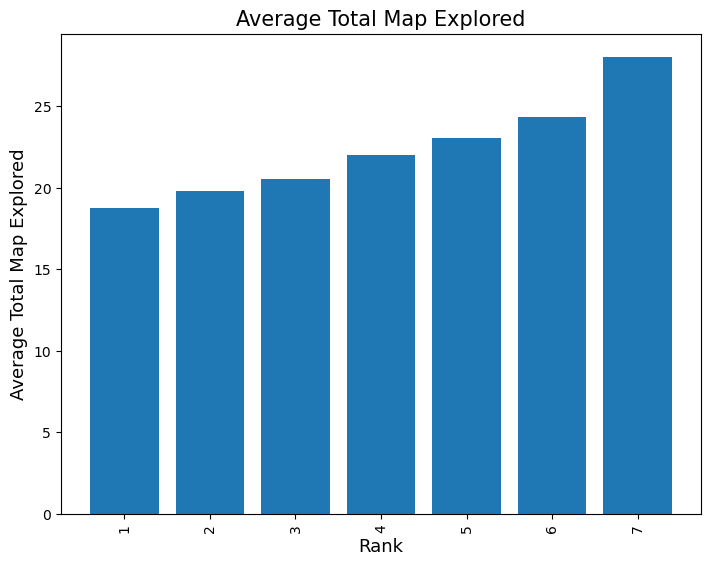

<Figure size 640x100 with 0 Axes>

<Figure size 100x480 with 0 Axes>

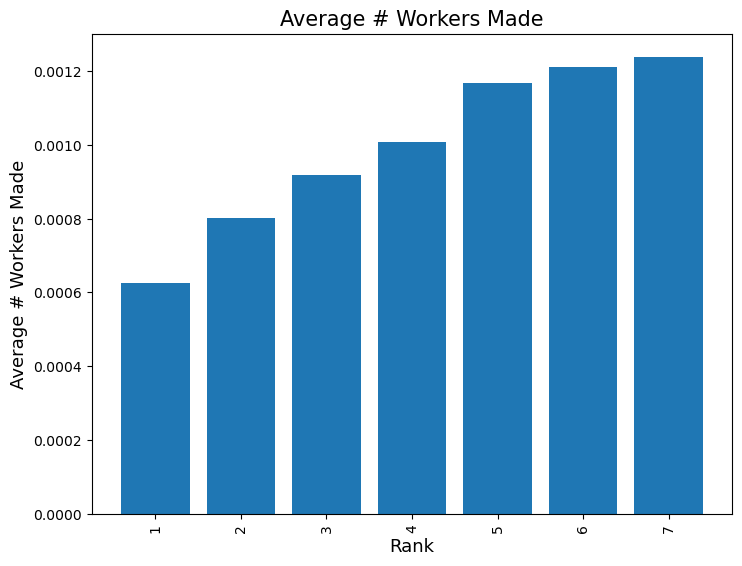

<Figure size 640x100 with 0 Axes>

In [149]:
avg_UniqueHotkeys = df_no_question_marks[['LeagueIndex', 'UniqueHotkeys']]
avg_UniqueHotkeys = avg_UniqueHotkeys.groupby('LeagueIndex', as_index=False).mean() 

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(avg_UniqueHotkeys['LeagueIndex'], avg_UniqueHotkeys['UniqueHotkeys'])
plt.xticks(rotation=90)

#add title to scatterplot and axis titles
plt.title('Average Unique Hotkeys per Rank', fontsize = 15)

plt.xlabel('Rank', fontsize=13)
plt.ylabel('Average # of Unique Hotkeys', fontsize=13)
plt.figure().set_figheight(1)

plt.show()

avg_TotalMapExplored = df_no_question_marks[['LeagueIndex', 'TotalMapExplored']]
avg_TotalMapExplored = avg_TotalMapExplored.groupby('LeagueIndex', as_index=False).mean() 

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(avg_TotalMapExplored['LeagueIndex'], avg_TotalMapExplored['TotalMapExplored'])
plt.xticks(rotation=90)

#add title to scatterplot and axis titles
plt.title('Average Total Map Explored', fontsize = 15)

plt.xlabel('Rank', fontsize=13)
plt.ylabel('Average Total Map Explored', fontsize=13)
plt.figure().set_figheight(1)
plt.figure().set_figwidth(1)
plt.show()

avg_WorkersMade = df_no_question_marks[['LeagueIndex', 'WorkersMade']]

avg_WorkersMade = avg_WorkersMade.groupby('LeagueIndex', as_index=False).mean() 

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(avg_WorkersMade['LeagueIndex'], avg_WorkersMade['WorkersMade'])
plt.xticks(rotation=90)

#add title to scatterplot and axis titles
plt.title('Average # Workers Made', fontsize = 15)

plt.xlabel('Rank', fontsize=13)
plt.ylabel('Average # Workers Made', fontsize=13)
plt.figure().set_figheight(1)
# plt.figure().set_figwidth(0)
plt.show()


##### Taking a look at the Correlation Map

Looking at the "LeagueIndex" on the Y-axis compared to the rest of the features on the X-axis. This graph shows us the best predictors are "APM", "NumberOfPACs", and "AssignToHotkeys" because the lighter the color the more correlation between the two variables. "GapBetweenPACs" and "ActionLatency" gives us the lowest correlation. 

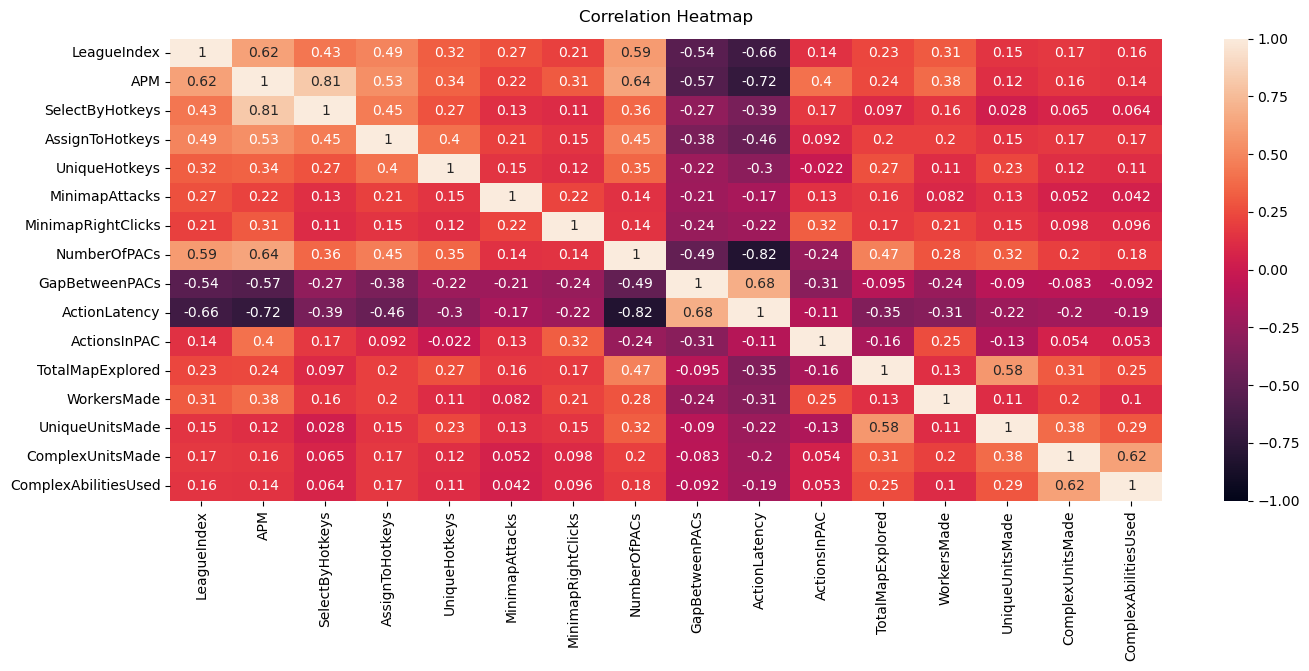

In [150]:
#Correlation map to see how features are correlated with LeagueIndex

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_no_question_marks.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### Checking for Skewed data and Handling Skewed Data 

Data is skewed when its distribution curve is asymmetrical (as compared to a normal distribution curve that is perfectly symmetrical) and skewness is the measure of asymmetry. The skewness for a normal distribution is 0. 

##### Why are we considering the effects of skewed data? 

Skewed data degrades the model’s ability to describe typical cases as it has to deal with rare cases on extreme values. For example, right skewed data will predict better on data points with lower value as compared to those with higher values. Skewed data also does not work well with many statistical methods. 

To ensure that the machine learning model capabilities is not affected, skewed data has to be transformed to approximate to a normal distribution. 

In [151]:
skewness = df_no_question_marks.skew().sort_values(ascending=False)
skewness

TotalHours              57.565349
MinimapAttacks           5.152513
ComplexAbilitiesUsed     3.801390
SelectByHotkeys          2.983733
HoursPerWeek             2.673157
ComplexUnitsMade         2.285522
MinimapRightClicks       2.220064
GapBetweenPACs           1.951723
WorkersMade              1.665229
ActionsInPAC             1.612722
ActionLatency            1.195672
Age                      1.151892
APM                      0.992196
AssignToHotkeys          0.834636
TotalMapExplored         0.632778
NumberOfPACs             0.496193
UniqueHotkeys            0.196800
UniqueUnitsMade          0.186771
LeagueIndex             -0.361509
dtype: float64

Woah! TotalHours is totally skewed, and to a huge amount. It may be worth dropping this column depending if it will make our model worse or better.

##### Looking at Normal Distribution for "APM"

The normal distribution is really skewed to the right. What we can do is normalize the data. 


 mu = 114.58 and sigma = 48.10



/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


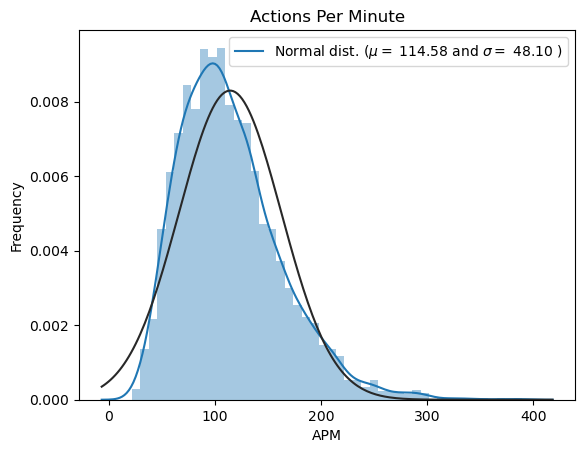

<Figure size 640x480 with 0 Axes>

In [154]:
sns.distplot(df_no_question_marks['APM'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_no_question_marks['APM'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Actions Per Minute')

fig = plt.figure()
plt.show()

##### Applying Log-Log Transform

In [155]:
df_no_question_marks = df_no_question_marks.astype(float)

In [156]:
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    df_no_question_marks[feat] = np.log1p(df_no_question_marks[feat])
    
#all_data[skewed_features] = boxcox1p(all_data[skewed_features])

Checking the distribution of "APM" again

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 4.66 and sigma = 0.42



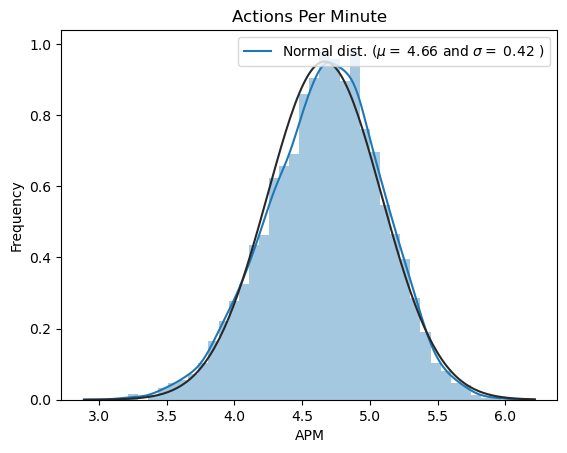

<Figure size 640x480 with 0 Axes>

In [158]:
sns.distplot(df_no_question_marks['APM'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_no_question_marks['APM'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Actions Per Minute')

fig = plt.figure()
plt.show()

### Training Data

In [159]:
df_no_question_marks = df_no_question_marks.astype(int)

In [160]:
X_train, X_test, y_train, y_test = train_test_split(df_no_question_marks, 
                                                    df_no_question_marks['LeagueIndex'], 
                                                    test_size = 0.25, 
                                                    random_state = 40)
# X_train

We want a well predicted performance. I am looking at using a neural network versus random forests.

I choose to use random forests because it is an ensemble of decision tress whereby the final/lead node will be the majority class for a classification problem. I chose to use a random forest instead of a decision tree because the logic is that a single even made of mediocre models will still be better than one good model. Random forests are less prone to overfitting which we consider when apply the model from training to test data. Overfitting can occur with a flexible model like decision tress where the model can memorize the training data and learn any noise in the data as well. This will make it unable to predict the test data/ classify accurately when applied to the test data. A random forest can reduce the high variance from a flexible model like a decision tree by combining many trees into one ensemble model. 

A neural network can be applied to more data types such as images, audio, and test. Since we have tabular data, it is worth to check the Random Forests first because it requires less preprocessing and the training process is simpler. If we are not satisfied with the model performance, we can try to tune and train Neural Network. 

In the end I used both Random Forests and Neural Networks to see the accuracy. It looks like after adjusting for the skewedness of the data, our accuracy went from around 30% to 90%. 

### Evaluating and Fitting the Model

In [133]:
X_train = X_train.drop(columns = 'LeagueIndex')
X_test = X_test.drop(columns = 'LeagueIndex')

GameID does not have an affect on Rank, therefore I drop this column

In [134]:
new_X_train = X_train[['APM', 'NumberOfPACs', 'AssignToHotkeys']]
new_X_test = X_test[['APM', 'NumberOfPACs', 'AssignToHotkeys']]

In [135]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

* After my first attempt in building the RandomForestClassifier model, using almost all of the features, the accuracy was really low. I believe that is because not all features are as important as some features. Therefore using what we learned in EDA I am going to see what features to best use. 
* I will also apply an ensemble method in addition to random forests to generalize this model. 


In [136]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9029940119760479


#### Trying Neural Networks for Classification

In [139]:
clf = MLPClassifier(solver='adam', alpha=0.0001, hidden_layer_sizes=(50, 5, 5), activation= 'tanh', random_state=1, learning_rate='adaptive',
                    max_iter=400)
# 'activation': ['tanh', 'relu'],
#  'solver': ['sgd', 'adam', lbfgs']
    # 'alpha': [0.0001, 0.05],
    # 'learning_rate': ['constant','adaptive'],

train_x = new_X_train
train_y = y_train

clf.fit(train_x, train_y)
# predict test
y_pred = clf.predict(new_X_test)
# accuracy
# y_test
# y_pred

In [140]:
accuracy_score(y_pred, y_test)

0.925748502994012